## Work
1. 請比較使用 l1, l1_l2 及不同比例下的訓練結果

In [1]:
import os
import keras

# Disable GPU
os.environ["CUDA_VISIBLE_DEVICES"] = ""

# 預防錯誤： OMP: Error #15: Initializing libiomp5.dylib, but found libiomp5.dylib already initialized.
os.environ['KMP_DUPLICATE_LIB_OK'] = 'True'

Using TensorFlow backend.


In [2]:
train, test = keras.datasets.cifar10.load_data()

In [3]:
## 資料前處理
def preproc_x(x, flatten=True):
    x = x / 255.
    if flatten:
        x = x.reshape((len(x), -1))
    return x

def preproc_y(y, num_classes=10):
    if y.shape[-1] == 1:
        y = keras.utils.to_categorical(y, num_classes)
    return y    

In [4]:
x_train, y_train = train
x_test, y_test = test

# Preproc the inputs
x_train = preproc_x(x_train)
x_test = preproc_x(x_test)

# Preprc the outputs
y_train = preproc_y(y_train)
y_test = preproc_y(y_test)

In [5]:
from keras.regularizers import l1, l2, l1_l2
"""
l1(l=0.01): L1 weight regularization penalty, also known as LASSO
l2(l=0.01): L2 weight regularization penalty, also known as weight decay, or Ridge
l1l2(l1=0.01, l2=0.01): L1-L2 weight regularization penalty, also known as ElasticNet
"""

def build_mlp(input_shape:int, output_units=10, regularizer=None):
    """
    使用兩層隱藏層，一個輸出層(softmax)
    """
    input_layer = keras.layers.Input(input_shape)
    x = keras.layers.Dense(units=128, activation="relu", kernel_regularizer= regularizer, name="hidden_layer_0")(input_layer)
    x = keras.layers.Dense(units=64, activation="relu", kernel_regularizer= regularizer, name="hidden_layer_1")(x)
    out = keras.layers.Dense(units=output_units, activation="softmax", name="output")(x)
    model = keras.models.Model(inputs=[input_layer], outputs=[out])
    
    return model

In [14]:
"""Code Here
設定超參數
"""
LEARNING_RATE = 1e-3
EPOCHS = 50
BATCH_SIZE = 256
MOMENTUM = 0.95
L1_RATIOS = [0.01, 0.001, 0.0001]
L2_RATIOS = [0.01, 0.0001]

In [7]:
def run_model(results: dict, reg_name: str, l1_ratio: float, l2_ratio= None):
    keras.backend.clear_session() # 把舊的 Graph 清掉
    print("Experiment with regularizer = %s" % (reg_name))
    
    if reg_name =='l1':
        regularizer = l1(l=l1_ratio)
    elif reg_name =='l1l2': 
        regularizer = l1_l2(l1=l1_ratio, l2=l2_ratio)
    else:
        raise ValueError('No this regularizer' + reg_name)

    model = build_mlp(input_shape=x_train.shape[1:], regularizer=regularizer)
    model.summary()
    optimizer = keras.optimizers.SGD(lr=LEARNING_RATE, nesterov=True, momentum=MOMENTUM)
    model.compile(loss="categorical_crossentropy", metrics=["accuracy"], optimizer=optimizer)

    model.fit(x_train, y_train, 
              epochs=EPOCHS, 
              batch_size=BATCH_SIZE, 
              validation_data=(x_test, y_test), 
              shuffle=True)
    
    # Collect results
    train_loss = model.history.history["loss"]
    valid_loss = model.history.history["val_loss"]
    train_acc = model.history.history["acc"]
    valid_acc = model.history.history["val_acc"]
    
    if l2_ratio:
        exp_name_tag = "exp-{}-{}-{}".format(reg_name, str(l1_ratio), str(l2_ratio))
    else:
        exp_name_tag = "exp-{}-{}".format(reg_name, str(l1_ratio))

    results[exp_name_tag] = {'train-loss': train_loss,
                             'valid-loss': valid_loss,
                             'train-acc': train_acc,
                             'valid-acc': valid_acc}

In [8]:
import matplotlib.pyplot as plt
%matplotlib inline
color_bar = ["r", "g", "b", "y", "m", "k"]

def drawing(results: dict):
    plt.figure(figsize=(8,6))
    for i, cond in enumerate(results.keys()):
        plt.plot(range(len(results[cond]['train-loss'])),results[cond]['train-loss'], '-', label=cond, color=color_bar[i])
        plt.plot(range(len(results[cond]['valid-loss'])),results[cond]['valid-loss'], '--', label=cond, color=color_bar[i])
    plt.title("Loss")
    plt.ylim([0, 5])
    plt.legend()
    plt.show()

    plt.figure(figsize=(8,6))
    for i, cond in enumerate(results.keys()):
        plt.plot(range(len(results[cond]['train-acc'])),results[cond]['train-acc'], '-', label=cond, color=color_bar[i])
        plt.plot(range(len(results[cond]['valid-acc'])),results[cond]['valid-acc'], '--', label=cond, color=color_bar[i])
    plt.title("Accuracy")
    plt.legend()
    plt.show()

Experiment with regularizer = l1
Instructions for updating:
Colocations handled automatically by placer.
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 3072)              0         
_________________________________________________________________
hidden_layer_0 (Dense)       (None, 128)               393344    
_________________________________________________________________
hidden_layer_1 (Dense)       (None, 64)                8256      
_________________________________________________________________
output (Dense)               (None, 10)                650       
Total params: 402,250
Trainable params: 402,250
Non-trainable params: 0
_________________________________________________________________
Instructions for updating:
Use tf.cast instead.
Train on 50000 samples, validate on 10000 samples
Epoch 1/50
50000/50000 [==============================] - 12s 242

Epoch 49/50
50000/50000 [==============================] - 5s 109us/step - loss: 2.2013 - acc: 0.1881 - val_loss: 2.2041 - val_acc: 0.1793
Epoch 50/50
50000/50000 [==============================] - 5s 102us/step - loss: 2.2041 - acc: 0.1865 - val_loss: 2.1893 - val_acc: 0.1999
Experiment with regularizer = l1
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 3072)              0         
_________________________________________________________________
hidden_layer_0 (Dense)       (None, 128)               393344    
_________________________________________________________________
hidden_layer_1 (Dense)       (None, 64)                8256      
_________________________________________________________________
output (Dense)               (None, 10)                650       
Total params: 402,250
Trainable params: 402,250
Non-trainable params: 0
_______________________

Train on 50000 samples, validate on 10000 samples
Epoch 1/50
50000/50000 [==============================] - 6s 125us/step - loss: 2.9622 - acc: 0.2674 - val_loss: 2.7992 - val_acc: 0.3297
Epoch 2/50
50000/50000 [==============================] - 5s 104us/step - loss: 2.7445 - acc: 0.3516 - val_loss: 2.7069 - val_acc: 0.3520
Epoch 3/50
50000/50000 [==============================] - 5s 104us/step - loss: 2.6648 - acc: 0.3768 - val_loss: 2.6315 - val_acc: 0.3851
Epoch 4/50
50000/50000 [==============================] - 5s 103us/step - loss: 2.6041 - acc: 0.3952 - val_loss: 2.5814 - val_acc: 0.3970
Epoch 5/50
50000/50000 [==============================] - 5s 103us/step - loss: 2.5545 - acc: 0.4072 - val_loss: 2.5364 - val_acc: 0.4138
Epoch 6/50
50000/50000 [==============================] - 5s 103us/step - loss: 2.5098 - acc: 0.4198 - val_loss: 2.5003 - val_acc: 0.4202
Epoch 7/50
50000/50000 [==============================] - 5s 107us/step - loss: 2.4707 - acc: 0.4299 - val_loss: 2.4603 - 

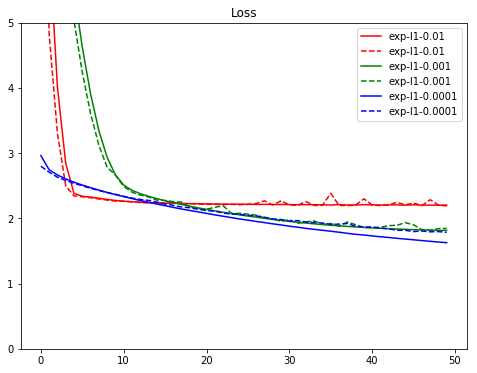

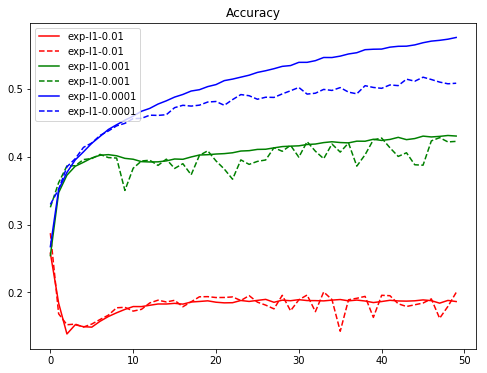

In [9]:
# L1
results = {}
for ratio in L1_RATIOS:
    run_model(results, 'l1', ratio)

drawing(results)

Experiment with regularizer = l1l2
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 3072)              0         
_________________________________________________________________
hidden_layer_0 (Dense)       (None, 128)               393344    
_________________________________________________________________
hidden_layer_1 (Dense)       (None, 64)                8256      
_________________________________________________________________
output (Dense)               (None, 10)                650       
Total params: 402,250
Trainable params: 402,250
Non-trainable params: 0
_________________________________________________________________
Train on 50000 samples, validate on 10000 samples
Epoch 1/50
50000/50000 [==============================] - 9s 175us/step - loss: 47.0191 - acc: 0.2474 - val_loss: 9.0500 - val_acc: 0.2692
Epoch 2/50
50000/50000 [====================

Train on 50000 samples, validate on 10000 samples
Epoch 1/50
50000/50000 [==============================] - 6s 121us/step - loss: 47.1756 - acc: 0.2478 - val_loss: 10.1411 - val_acc: 0.2779
Epoch 2/50
50000/50000 [==============================] - 5s 99us/step - loss: 6.1492 - acc: 0.1538 - val_loss: 4.7573 - val_acc: 0.1000
Epoch 3/50
50000/50000 [==============================] - 5s 100us/step - loss: 3.9556 - acc: 0.1194 - val_loss: 3.2618 - val_acc: 0.1024
Epoch 4/50
50000/50000 [==============================] - 5s 100us/step - loss: 2.8136 - acc: 0.1000 - val_loss: 2.4798 - val_acc: 0.1000
Epoch 5/50
50000/50000 [==============================] - 5s 100us/step - loss: 2.3741 - acc: 0.0975 - val_loss: 2.3407 - val_acc: 0.1000
Epoch 6/50
50000/50000 [==============================] - 5s 100us/step - loss: 2.3398 - acc: 0.0982 - val_loss: 2.3395 - val_acc: 0.1000
Epoch 7/50
50000/50000 [==============================] - 5s 100us/step - loss: 2.3396 - acc: 0.0967 - val_loss: 2.3395 -

Epoch 3/50
50000/50000 [==============================] - 5s 100us/step - loss: 7.7571 - acc: 0.3601 - val_loss: 6.7290 - val_acc: 0.3625
Epoch 4/50
50000/50000 [==============================] - 5s 100us/step - loss: 5.8856 - acc: 0.3693 - val_loss: 5.1025 - val_acc: 0.3727
Epoch 5/50
50000/50000 [==============================] - 5s 100us/step - loss: 4.4831 - acc: 0.3708 - val_loss: 3.9169 - val_acc: 0.3698
Epoch 6/50
50000/50000 [==============================] - 5s 100us/step - loss: 3.4991 - acc: 0.3706 - val_loss: 3.1303 - val_acc: 0.3709
Epoch 7/50
50000/50000 [==============================] - 5s 100us/step - loss: 2.8852 - acc: 0.3642 - val_loss: 2.6834 - val_acc: 0.3651
Epoch 8/50
50000/50000 [==============================] - 5s 100us/step - loss: 2.5660 - acc: 0.3586 - val_loss: 2.4792 - val_acc: 0.3474
Epoch 9/50
50000/50000 [==============================] - 5s 100us/step - loss: 2.4215 - acc: 0.3518 - val_loss: 2.3687 - val_acc: 0.3468
Epoch 10/50
50000/50000 [=========

50000/50000 [==============================] - 5s 100us/step - loss: 5.5100 - acc: 0.3822 - val_loss: 5.0431 - val_acc: 0.3885
Epoch 6/50
50000/50000 [==============================] - 5s 99us/step - loss: 4.6295 - acc: 0.3893 - val_loss: 4.2393 - val_acc: 0.3933
Epoch 7/50
50000/50000 [==============================] - 5s 99us/step - loss: 3.9067 - acc: 0.3936 - val_loss: 3.6100 - val_acc: 0.3889
Epoch 8/50
50000/50000 [==============================] - 5s 100us/step - loss: 3.3411 - acc: 0.3960 - val_loss: 3.1083 - val_acc: 0.3936
Epoch 9/50
50000/50000 [==============================] - 5s 99us/step - loss: 2.9292 - acc: 0.3947 - val_loss: 2.7839 - val_acc: 0.3868
Epoch 10/50
50000/50000 [==============================] - 5s 100us/step - loss: 2.6589 - acc: 0.3915 - val_loss: 2.5676 - val_acc: 0.3847
Epoch 11/50
50000/50000 [==============================] - 5s 104us/step - loss: 2.5041 - acc: 0.3899 - val_loss: 2.4922 - val_acc: 0.3572
Epoch 12/50
50000/50000 [=====================

50000/50000 [==============================] - 7s 136us/step - loss: 3.2558 - acc: 0.4077 - val_loss: 3.1296 - val_acc: 0.4140
Epoch 8/50
50000/50000 [==============================] - 7s 132us/step - loss: 3.0197 - acc: 0.4118 - val_loss: 2.9121 - val_acc: 0.4162
Epoch 9/50
50000/50000 [==============================] - 6s 122us/step - loss: 2.8165 - acc: 0.4196 - val_loss: 2.7307 - val_acc: 0.4147
Epoch 10/50
50000/50000 [==============================] - 6s 111us/step - loss: 2.6460 - acc: 0.4231 - val_loss: 2.5716 - val_acc: 0.4284
Epoch 11/50
50000/50000 [==============================] - 6s 120us/step - loss: 2.5007 - acc: 0.4281 - val_loss: 2.4364 - val_acc: 0.4289
Epoch 12/50
50000/50000 [==============================] - 6s 113us/step - loss: 2.3769 - acc: 0.4315 - val_loss: 2.3223 - val_acc: 0.4324
Epoch 13/50
50000/50000 [==============================] - 6s 118us/step - loss: 2.2726 - acc: 0.4352 - val_loss: 2.2279 - val_acc: 0.4351
Epoch 14/50
50000/50000 [================

50000/50000 [==============================] - 5s 109us/step - loss: 2.4215 - acc: 0.4458 - val_loss: 2.4160 - val_acc: 0.4406
Epoch 10/50
50000/50000 [==============================] - 5s 109us/step - loss: 2.3893 - acc: 0.4503 - val_loss: 2.3881 - val_acc: 0.4467
Epoch 11/50
50000/50000 [==============================] - 5s 110us/step - loss: 2.3585 - acc: 0.4554 - val_loss: 2.3598 - val_acc: 0.4496
Epoch 12/50
50000/50000 [==============================] - 5s 109us/step - loss: 2.3289 - acc: 0.4623 - val_loss: 2.3338 - val_acc: 0.4531
Epoch 13/50
50000/50000 [==============================] - 6s 110us/step - loss: 2.3010 - acc: 0.4665 - val_loss: 2.3152 - val_acc: 0.4599
Epoch 14/50
50000/50000 [==============================] - 6s 111us/step - loss: 2.2731 - acc: 0.4727 - val_loss: 2.2903 - val_acc: 0.4582
Epoch 15/50
50000/50000 [==============================] - 5s 110us/step - loss: 2.2472 - acc: 0.4762 - val_loss: 2.2682 - val_acc: 0.4620
Epoch 16/50
50000/50000 [==============

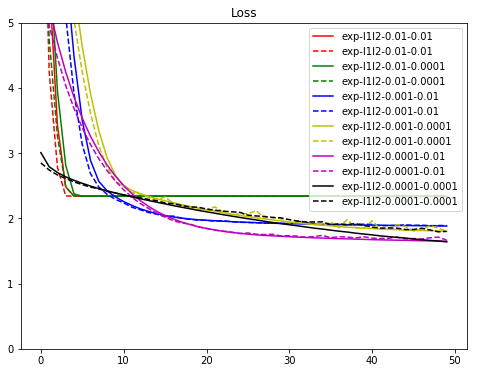

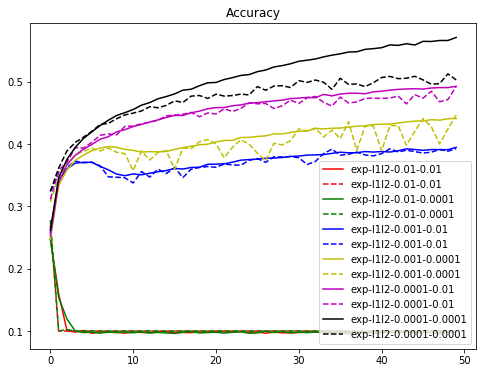

In [15]:
# L1L2
results = {}

for l1_ratio in L1_RATIOS:
    for l2_ratio in L2_RATIOS:
            run_model(results, 'l1l2', l1_ratio=l1_ratio, l2_ratio=l2_ratio)


drawing(results)            

### Answer:

- 以L1為regularizer, loss及accuracy的變化情況如下

![Loss](images/d81/l1_loss.png)

![Accuracy](images/d81/l1_accuracy.png)

- 以L1_L2為regularizer, loss及accuracy的變化情況如下

![Loss](images/d81/l1l2_loss.png)

![Accuracy](images/d81/l1l2_accuracy.png)
